In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import random
# from shapely.geometry import Point
import copy
import time
import bisect
from scipy.stats import rankdata

In [ ]:
# NOTES
# Distance ranking: make sure in the grid view that equal distances give equal ranking
 # (Same for orientation rankings)

In [19]:
geodata = gpd.read_file('./Data/LADs.geojson').to_crs('epsg:27700')
# geodata = geodata[['E09' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata = geodata[['W' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata['dummy'] = geodata['geometry'].apply(lambda g: 1)
geodata['centroid'] = geodata.centroid

geo_list = geodata['LAD20CD'].values # Definitive list with definitive order of geometry codes

<AxesSubplot:>

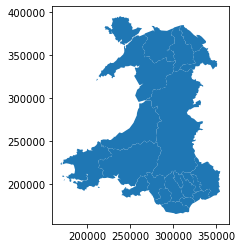

In [12]:
geodata.plot()

In [13]:
geodata

,LAD20CD,LAD20NM,geometry,dummy,centroid
357,W06000001,Isle of Anglesey,"POLYGON ((240000.004 394577.908, 240445.514 39...",1,POINT (241835.228 379233.676)
358,W06000002,Gwynedd,"MULTIPOLYGON (((267978.708 372366.304, 270868....",1,POINT (264136.399 334667.737)
359,W06000003,Conwy,"POLYGON ((299724.870 380889.607, 300371.113 37...",1,POINT (284072.324 361552.108)
360,W06000004,Denbighshire,"POLYGON ((324414.214 353387.707, 323145.711 35...",1,POINT (309507.880 355562.623)
361,W06000005,Flintshire,"MULTIPOLYGON (((313293.515 382786.601, 315287....",1,POINT (322547.437 368615.133)
362,W06000006,Wrexham,"POLYGON ((351298.712 343127.004, 350716.010 34...",1,POINT (331695.185 344175.768)
363,W06000008,Ceredigion,"POLYGON ((279749.210 249226.602, 277768.013 24...",1,POINT (258559.569 263733.729)
364,W06000009,Pembrokeshire,"MULTIPOLYGON (((216364.016 243983.404, 217396....",1,POINT (201337.424 221180.436)
365,W06000010,Carmarthenshire,"POLYGON ((279749.210 249226.602, 282307.116 24...",1,POINT (251556.904 225139.754)
366,W06000011,Swansea,"MULTIPOLYGON (((262123.115 210278.302, 264479....",1,POINT (258170.595 195828.191)


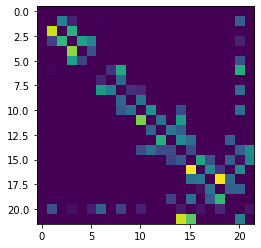

In [47]:
plt.imshow(array)

In [43]:
neighbours[neighbours['LAD20CD_left']==geo_list[-1]]

,LAD20CD_left,LAD20CD_right,weight
378,W06000024,W06000023,0.207431
378,W06000024,W06000016,0.438795
378,W06000024,W06000018,0.353774


In [45]:
neighbours[neighbours['LAD20CD_right']==geo_list[-1]]

,LAD20CD_left,LAD20CD_right,weight
371,W06000016,W06000024,0.231222
372,W06000018,W06000024,0.213203
377,W06000023,W06000024,0.024348


In [49]:
def make_df_array(row_labels, col_labels, values):
    
    dtype = values.dtype
    array = np.zeros((len(geo_list), len(geo_list)), dtype=dtype)
    
    for row_num, row_lab in enumerate(geo_list):
        for col_num, col_lab in enumerate(geo_list):
            vs = values[(row_labels==row_lab) & (col_labels==col_lab)]
            if len(vs)>0:
                array[row_num, col_num] = vs[0]
            
    return array



# Identify which geometries are neighbours

g_copygeo = copy.copy(geodata)
g_copygeo['geocopy'] = g_copygeo.geometry

# Find all geometries which touch each other
neighbours = g_copygeo.sjoin(g_copygeo, how='inner', predicate='touches')
neighbours = neighbours.loc[neighbours['LAD20CD_left']!=neighbours['LAD20CD_right']]

# Find the length of the border as a fraction of the left geometry's total border
neighbours['intersection'] = neighbours.apply(lambda row: row['geocopy_left'].intersection(row['geocopy_right']), axis=1)
neighbours['weight'] = neighbours.apply(lambda row: row['intersection'].length/row['geocopy_left'].length, axis=1)

neighbours = neighbours[['LAD20CD_left', 'LAD20CD_right', 'weight']]

neighbours_array = make_df_array(neighbours['LAD20CD_left'].values, neighbours['LAD20CD_right'].values, neighbours['weight'].values)

/home/tpeterken/anaconda3/envs/AutoCartogram/lib/python3.10/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/home/tpeterken/anaconda3/envs/AutoCartogram/lib/python3.10/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/home/tpeterken/anaconda3/envs/AutoCartogram/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  numbe

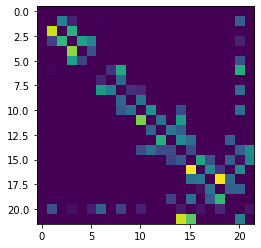

In [50]:
plt.imshow(neighbours_array)

In [57]:
# Measure the distance between each pair of geometries

def angle_between(loca, locb):
    xa, ya = loca.xy
    xb, yb = locb.xy    
    return np.arctan2(yb[0]-ya[0], xb[0]-xa[0])

crossjoin = geodata.merge(geodata, how='inner', on='dummy', suffixes=('_left', '_right'))
crossjoin = crossjoin.loc[crossjoin['LAD20CD_left']!=crossjoin['LAD20CD_right']]
crossjoin['distance'] = crossjoin.apply(lambda row: row['geometry_left'].distance(row['geometry_right']), axis=1)
crossjoin['target_distance_rank'] = crossjoin.groupby('LAD20CD_left')['distance'].rank()
crossjoin['target_angle'] = crossjoin.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
distance_ranking = crossjoin[['LAD20CD_left', 'LAD20CD_right', 'target_distance_rank', 'target_angle']]

distance_array = make_df_array(distance_ranking['LAD20CD_left'].values, distance_ranking['LAD20CD_right'], distance_ranking['target_distance_rank'].values)
angle_array = make_df_array(distance_ranking['LAD20CD_left'].values, distance_ranking['LAD20CD_right'], distance_ranking['target_angle'].values)

In [53]:
distance_ranking

,LAD20CD_left,LAD20CD_right,target_distance_rank,target_angle
1,W06000001,W06000002,1.0,-1.106822
2,W06000001,W06000003,2.0,-0.396460
3,W06000001,W06000004,3.0,-0.336486
4,W06000001,W06000005,4.0,-0.130809
5,W06000001,W06000006,6.0,-0.371977
...,...,...,...,...
478,W06000024,W06000019,4.0,0.220886
479,W06000024,W06000020,7.0,-0.237013
480,W06000024,W06000021,9.0,0.065829
481,W06000024,W06000022,10.0,-0.597980


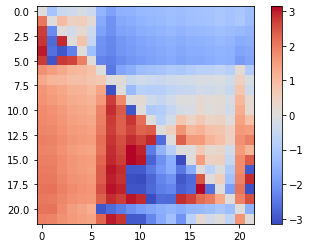

In [66]:
im = plt.imshow(angle_array, cmap='coolwarm')
plt.colorbar(im)

In [63]:
distance_ranking[distance_ranking['LAD20CD_left']==distance_ranking['LAD20CD_right']]

,LAD20CD_left,LAD20CD_right,target_distance_rank,target_angle


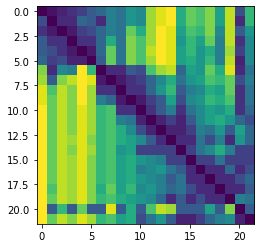

In [52]:
plt.imshow(distance_array)

In [69]:
# Measure the north-south and east-west ranking of all 

orientation_ranking = copy.copy(geodata)[['LAD20CD', 'centroid']]
orientation_ranking['x'] = orientation_ranking['centroid'].apply(lambda c: c.xy[0][0])
orientation_ranking['y'] = orientation_ranking['centroid'].apply(lambda c: c.xy[1][0])
orientation_ranking['EW'] = orientation_ranking['x'].rank()
orientation_ranking['NS'] = orientation_ranking['y'].rank()
orientation_ranking = orientation_ranking[['LAD20CD', 'EW', 'NS']]

northsouth_vector = [orientation_ranking[orientation_ranking['LAD20CD']==g]['NS'].values[0] for g in geo_list]
westeast_vector = [orientation_ranking[orientation_ranking['LAD20CD']==g]['EW'].values[0] for g in geo_list]

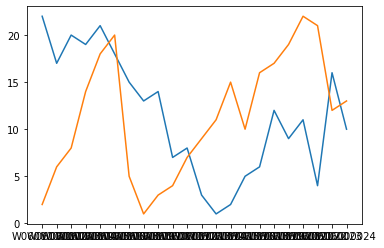

In [75]:
plt.plot(geo_list, northsouth_vector)
plt.plot(geo_list, westeast_vector)

In [58]:
number_of_geographies = len(geodata)

max_number_of_spaces = 2 # in multiples of the number of input geographies



initial_axis_ratio = (geodata.total_bounds[3]-geodata.total_bounds[1])/(geodata.total_bounds[2]-geodata.total_bounds[0])

In [99]:
def make_integers(position_list):
    # Turns a list of values into a list of integer values depending on the values' ranking
    ranks = rankdata(position_list)
    return np.array(ranks, dtype=int)-1


def make_grid(
    requested_number, # Target number of positions in the grid
    axis_ratio, # Target axis ratio
    actual_number=number_of_geographies, # Number of geographies which have to fit in the grid
    min_spaces=0, # Minimum multiple of actual_number which can be occupied by empties
    max_spaces=max_number_of_spaces # Maximum multiple of actual_number which can be occupied by empties
):    
    
    # Define basic naive dimensions
    X_size = int(np.round(np.sqrt(requested_number/axis_ratio)))
    Y_size = int(np.round(axis_ratio*X_size))    
    grid_size = X_size*Y_size
    
    # Adjust the X-size up or down to accommodate min_spaces and max_spaces
    while grid_size <= (min_spaces+1)*actual_number:
        X_size = X_size+1
        grid_size = X_size*Y_size
    while grid_size >= (max_spaces+1)*actual_number:
        X_size = X_size-1
        grid_size = X_size*Y_size
    
    # Return the final grid dimensions
    return (X_size, Y_size)


def number_of_empties(grid_dims, actual_number=number_of_geographies):
    return np.product(grid_dims)-actual_number

def make_positions_2d(grid_dims, position_list):
    return np.unravel_index(position_list, grid_dims, order='F')

def distance_matrix(x_list, y_list):
    a = [rankdata([np.sqrt((x1-x2)**2 + (y1-y2)**2) for x1,y1 in zip(x_list, y_list)])-1 for x2,y2 in zip(x_list, y_list)]
    return np.array(a)

def orientation_order(x_list, y_list):    
    return rankdata(y_list)-1, rankdata(x_list)-1 # NS, EW
    
    
def compare_


In [59]:
make_grid(32.6, initial_axis_ratio)

(5, 6)

In [78]:
orientation_order(*make_positions_2d((5,5), range(25)))

(array([ 3.,  3.,  3.,  3.,  3.,  8.,  8.,  8.,  8.,  8., 13., 13., 13.,
        13., 13., 18., 18., 18., 18., 18., 23., 23., 23., 23., 23.]),
 array([ 3.,  8., 13., 18., 23.,  3.,  8., 13., 18., 23.,  3.,  8., 13.,
        18., 23.,  3.,  8., 13., 18., 23.,  3.,  8., 13., 18., 23.]))

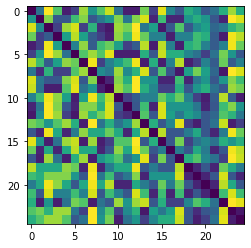

In [101]:
positions = make_integers(np.random.random(25))
locations = make_positions_2d((5,5), positions)

plt.imshow(distance_matrix(*locations))

In [97]:
np.unravel_index(range(25), (5,5))

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4]),
 array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
        2, 3, 4]))

In [98]:
positions

array([25,  7,  4,  6, 12, 10, 19,  9, 13,  8, 24, 11, 22, 14, 16, 21,  1,
        3,  5, 18,  2, 20, 15, 23, 17])